In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import sys
sys.path.append('gdrive/MyDrive/mldd')

In [ ]:
%%bash
add-apt-repository ppa:ubuntu-toolchain-r/test
apt-get update --fix-missing
apt-get dist-upgrade
wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
chmod +x Miniconda3-latest-Linux-x86_64.sh
./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
conda config --set always_yes yes --set changeps1 no
conda install -q -y -c conda-forge python=3.7 rdkit


 Toolchain test builds; see https://wiki.ubuntu.com/ToolChain

 More info: https://launchpad.net/~ubuntu-toolchain-r/+archive/ubuntu/test
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [73.9 kB]
Ign:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:11 https://developer.download.nv

--2022-01-04 15:00:12--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2022-01-04 15:00:12--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66709754 (64M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

     0K .......... .......... .......... .......... ..........  0% 42.9M 1s
    50K .......... .......... .......... .......... ..........

In [4]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

try:
    from rdkit import Chem
    from rdkit.Chem.Draw import IPythonConsole
except ImportError:
    print('Stopping RUNTIME. Colaboratory will restart automatically. Please run cell again.')
    exit()


In [ ]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

In [ ]:
import sys
sys.path

In [7]:
from mldd.data import Featurizer

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise ValueError("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


class GraphFeaturizer(Featurizer):
    def __call__(self, df):
        graphs = []
        labels = []
        for i, row in df.iterrows():
            y = row[self.y_column]
            smiles = row.smiles
            mol = Chem.MolFromSmiles(smiles)

            if not mol:
                print('featurizer mol None', y, smiles)
                continue
            
            edges = []
            for bond in mol.GetBonds():
                edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
                edges.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()])
            edges = np.array(edges)
            
            nodes = []
            for atom in mol.GetAtoms():
                results = one_of_k_encoding_unk(
                    atom.GetSymbol(),
                    [
                        'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S', 'Unknown'
                    ]
                ) + one_of_k_encoding(
                    atom.GetDegree(),
                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
                ) + one_of_k_encoding_unk(
                    atom.GetImplicitValence(),
                    [0, 1, 2, 3, 4, 5, 6]
                ) + [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + one_of_k_encoding_unk(
                    atom.GetHybridization(),
                    [
                        Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                        Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
                        Chem.rdchem.HybridizationType.SP3D2
                    ]
                ) + [atom.GetIsAromatic()] + one_of_k_encoding_unk(
                    atom.GetTotalNumHs(),
                    [0, 1, 2, 3, 4]
                )
                nodes.append(results)
            nodes = np.array(nodes)
            
            graphs.append((nodes, edges.T))
            labels.append(y)
        labels = np.array(labels)
        return graphs, labels

In [8]:
from torch_geometric.data import InMemoryDataset, Data  # TODO

class GraphDataset(InMemoryDataset):  # TODO
    def __init__(self, X, y, root, transform=None, pre_transform=None):
        self.dataset = (X, y)
        super().__init__(root, transform, pre_transform)
        
        self.download()
        self.process()

        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['data.pt']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        data = []
        # TODO (data should be a list of graphs)

        for (nodes, edges), target in zip(*self.dataset):
            nodes = torch.tensor(nodes, dtype=torch.float)
            edges = torch.tensor(edges, dtype=torch.long)
            target = torch.tensor(target, dtype=torch.float)
            
            graph = Data(x=nodes, edge_index=edges, y=target)
            graph.num_nodes = nodes.shape[0]
            data.append(graph)

        torch.save(data, self.raw_paths[0])
        

    def process(self):
        # Read data into huge `Data` list.
        data_list = torch.load(self.raw_paths[0])
        
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [14]:
from mldd.data import load_fold_indices
import pandas as pd
import numpy as np

def load_bbbp(split_path='gdrive/MyDrive/mldd/data/bbbp/split.npz'):
    df = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv')
    indices = np.load(split_path)
    return df, indices

In [ ]:
pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv').head()

In [ ]:
df,indices = load_bbbp(split_path='gdrive/MyDrive/mldd/data/bbbp/split.npz')
featurizer = GraphFeaturizer(y_column='p_np')


X_train, y_train = featurizer(df.iloc[indices['train']])
X_valid, y_valid = featurizer(df.iloc[indices['valid']])
X_test, y_test = featurizer(df.iloc[indices['test']])

In [17]:
from torch_geometric.loader import DataLoader as GraphDataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, Sequential as GraphSequential

from torch.nn import ReLU, Sigmoid
from torch_geometric.nn import GCNConv, Linear, global_mean_pool

import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm, trange
from torch.utils.data import TensorDataset, DataLoader

from typing import List, Tuple

from mldd.metrics import mae, rmse, rocauc, r_squared
from mldd.data import *

In [18]:
class GCNClassifier(torch.nn.Module):
    def __init__(self, input, hidden, output):
        super().__init__()

        self.input = None
        self.final_conv_acts = None
        self.final_conv_grads = None

        self.conv1 = GCNConv(input, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.conv3 = GCNConv(hidden, hidden)
        self.conv4 = GCNConv(hidden, output)
        self.linear = Linear(output, 1)
        self.relu = ReLU(inplace=True)
        self.sigmoid = Sigmoid()
    
    def activations_hook(self, grad):
        self.final_conv_grads = grad

    def forward(self, x, edge_index, batch):
        x.requires_grad = True
        self.input = x

        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.conv3(x, edge_index)
        x = self.relu(x)
        with torch.enable_grad():
            self.final_conv_acts = self.conv4(x, edge_index)
        self.final_conv_acts.register_hook(self.activations_hook)

        x = global_mean_pool(self.final_conv_acts, batch=batch)
        x = self.linear(x)

        x = self.sigmoid(x)

        return x

In [20]:
def train(X_train, y_train, X_valid, y_valid):
    # hyperparameters definition
    hidden_size = 512
    epochs = 50
    batch_size = 64
    learning_rate = 0.0001
    
    # model preparation
    model = GCNClassifier(input=len(X_train[0][0][0]), hidden=hidden_size, output=64)  # TODO
    model.train()
    
    # data preparation
    dataset = GraphDataset(X_train, y_train.reshape(-1, 1), root='bbbp-train')
    loader = GraphDataLoader(dataset, batch_size=batch_size, shuffle=True, )
    
    # training loop
    optimizer = torch.optim.Adam(params=model.parameters())  # TODO
    loss_fn = torch.nn.BCELoss()  # TODO
    for epoch in trange(1, epochs + 1, leave=False):
        for data in tqdm(loader, leave=False):
            x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
            
            model.zero_grad()
            preds = model(x, edge_index, batch)
            loss = loss_fn(preds, y.reshape(-1, 1))
            loss.backward()
            optimizer.step()
    return model


def predict(model, X_test, y_test):
    # hyperparameters definition
    # (but this doesn't change the training results, it's only to optimize the eval speed)
    batch_size = 64

    # data preparation
    dataset = GraphDataset(X_test, y_test.reshape(-1, 1), root='bbbp-test')
    loader = GraphDataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # evaluation loop
    preds_batches = []
    with torch.no_grad():
        for data in tqdm(loader):
            x, edge_index, batch = data.x, data.edge_index, data.batch
            
            preds = model(x, edge_index, batch)
            preds_batches.append(preds.cpu().detach().numpy())
    preds = np.concatenate(preds_batches)
    return preds

scores = []

In [21]:
# training
modelG = train(X_train, y_train, X_valid, y_valid)
    
# # evaluation
predictions = predict(modelG, X_test, y_test)
    
rmse_score = rmse(y_test, predictions.flatten())
mae_score = mae(y_test, predictions.flatten())
r2_score = r_squared(y_test, predictions.flatten())
roc_score = rocauc(y_test, predictions.flatten())
acc = (predictions.reshape(-1).round() == y_test).mean()
scores.append([rmse_score, mae_score, r2_score, roc_score])


scores = np.array(scores)
print('RMSE, MAE, R2, ROC AUC, ACCURACY = ' + \
      ', '.join(f'{mean:.2f}±{std:.3f}' for mean, std in zip(scores.mean(axis=0), scores.std(axis=0))) + f', {acc}')

Processing...
Done!


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Processing...
Done!


  0%|          | 0/4 [00:00<?, ?it/s]

RMSE, MAE, R2, ROC AUC, ACCURACY = 0.37±0.000, 0.24±0.000, 0.27±0.000, 0.87±0.000, 0.8341463414634146


In [22]:
torch.save(modelG, 'gdrive/MyDrive/mldd/GCNClassifier.pth')

/usr/local/lib/python3.7/dist-packages/torch/utils/hooks.py:62: UserWarning: backward hook <bound method GCNClassifier.activations_hook of GCNClassifier(
  (conv1): GCNConv(42, 512)
  (conv2): GCNConv(512, 512)
  (conv3): GCNConv(512, 512)
  (conv4): GCNConv(512, 64)
  (linear): Linear(64, 1, bias=True)
  (relu): ReLU(inplace=True)
  (sigmoid): Sigmoid()
)> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  "to suppress this warning".format(repr(hook)))


In [23]:
modelG = torch.load('gdrive/MyDrive/mldd/GCNClassifier.pth')

In [24]:
import torch.nn.functional as F

def grad_cam(final_conv_acts, final_conv_grads):
    node_heat_map = []
    alphas = torch.mean(final_conv_grads, axis=0)  # TODO (formula 1)
    for n in range(final_conv_acts.shape[0]): # nth node
        node_heat = F.relu(alphas @ final_conv_acts[n]).item()  # TODO (formula 2)
        node_heat_map.append(node_heat)
    return node_heat_map

In [27]:
df.iloc[110]

num                                        112
name                               oxiperomide
p_np                                         1
smiles    O=C1Nc2ccccc2N1C3CCN(CCOc4ccccc4)CC3
Name: 110, dtype: object

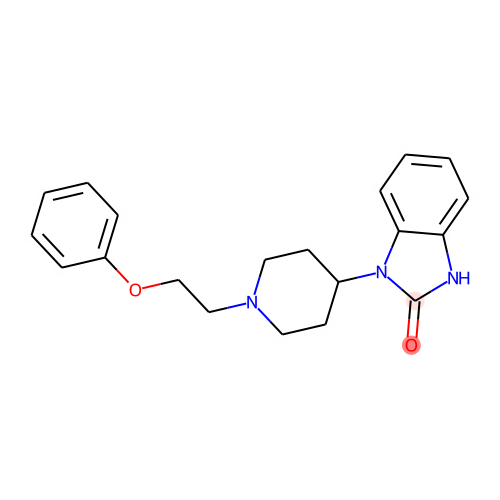

In [28]:
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

import matplotlib
import matplotlib.cm as cm

import pandas as pd

from sklearn.preprocessing import MinMaxScaler

compound_idx = 110
mol = Chem.MolFromSmiles(df.iloc[compound_idx].smiles)

graphs, labels = featurizer(df.iloc[compound_idx].to_frame().transpose())
X = graphs[0][0]
E = graphs[0][1]
data = Data(
    x=torch.FloatTensor(X),
    edge_index=torch.LongTensor(E)
)

x, edge_index, batch = data.x, data.edge_index, data.batch

modelG(x, edge_index, torch.zeros(x.shape[0], dtype=torch.int64))
atom_weights = grad_cam(modelG.final_conv_acts, modelG.final_conv_grads)
atom_weights = MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(atom_weights).reshape(-1, 1)).reshape(-1, )

atom_weights = np.array(atom_weights)
if (atom_weights > 0.).any():
    atom_weights = atom_weights / atom_weights.max() / 2

if len(atom_weights) > 0:
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    cmap = cm.get_cmap('bwr')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {
        i: plt_colors.to_rgba(atom_weights[i]) for i in range(len(atom_weights))
    }
    highlight_kwargs = {
        'highlightAtoms': list(range(len(atom_weights))),
        'highlightBonds': [],
        'highlightAtomColors': atom_colors
    }

d = rdMolDraw2D.MolDraw2DSVG(500, 500) # or MolDraw2DCairo to get PNGs
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, **highlight_kwargs)
d.FinishDrawing()
svg = d.GetDrawingText()
svg = svg.replace('svg:', '')
SVG(svg)

In [29]:
def saliency_map(input_grads):
    # print('saliency_map')
    node_saliency_map = []
    for n in range(input_grads.shape[0]): # nth node
        node_grads = input_grads[n,:]
        node_saliency = torch.norm(F.relu(node_grads)).item()
        node_saliency_map.append(node_saliency)
    return node_saliency_map

In [30]:
out = modelG(x, edge_index, torch.zeros(x.shape[0], dtype=torch.int64))
loss =  torch.nn.BCELoss()(out, torch.tensor(labels.reshape(-1, 1), dtype=torch.float32))
loss.backward()

In [31]:
saliency_atom_weights = saliency_map(modelG.input.grad)

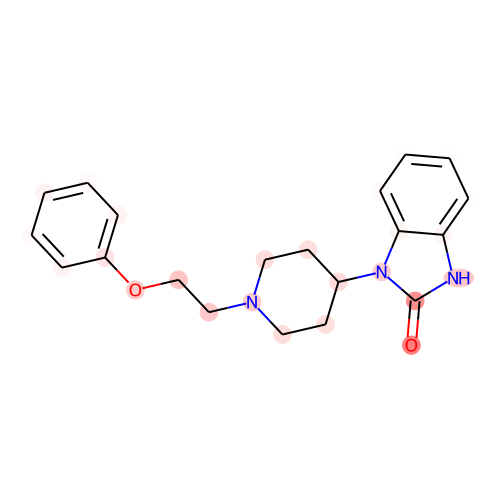

In [32]:
saliency_atom_weights = MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(saliency_atom_weights).reshape(-1, 1)).reshape(-1, )
if (saliency_atom_weights > 0.).any():
    saliency_atom_weights = saliency_atom_weights / saliency_atom_weights.max() / 2

if len(saliency_atom_weights) > 0:
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    cmap = cm.get_cmap('bwr')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {
        i: plt_colors.to_rgba(saliency_atom_weights[i]) for i in range(len(saliency_atom_weights))
    }
    highlight_kwargs = {
        'highlightAtoms': list(range(len(saliency_atom_weights))),
        'highlightBonds': [],
        'highlightAtomColors': atom_colors
    }

d = rdMolDraw2D.MolDraw2DSVG(500, 500) # or MolDraw2DCairo to get PNGs
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, **highlight_kwargs)
d.FinishDrawing()
svg = d.GetDrawingText()
svg = svg.replace('svg:', '')
SVG(svg)